# 1. Loading and Viewing Data

In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [3]:
image_size = (180, 180)
batch_size = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/train",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/val",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/chest-xray-pneumonia/chest_xray/test",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [43]:
def x_ray_count(dir_path):
    count = 0
    for path in os.listdir(dir_path):
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    return count

In [52]:
dir_path_normal = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
dir_path_pneumonia = r'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'

print('Normal: ', x_ray_count(dir_path_normal))
print('Pneumonia: ', x_ray_count(dir_path_pneumonia))

Normal:  1341
Pneumonia:  3875


By result we see that our train data unbalanced it's unfortunate, but we can partially handle using data augmentation.

In [4]:
def ploting_data(data):
    plt.figure(figsize=(10, 10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype('uint8'))
            if int(labels[i]) == 0:
                name = 'Normal'
            else: 
                name = 'Pneumonia'
            plt.title(name)
            plt.axis('off')

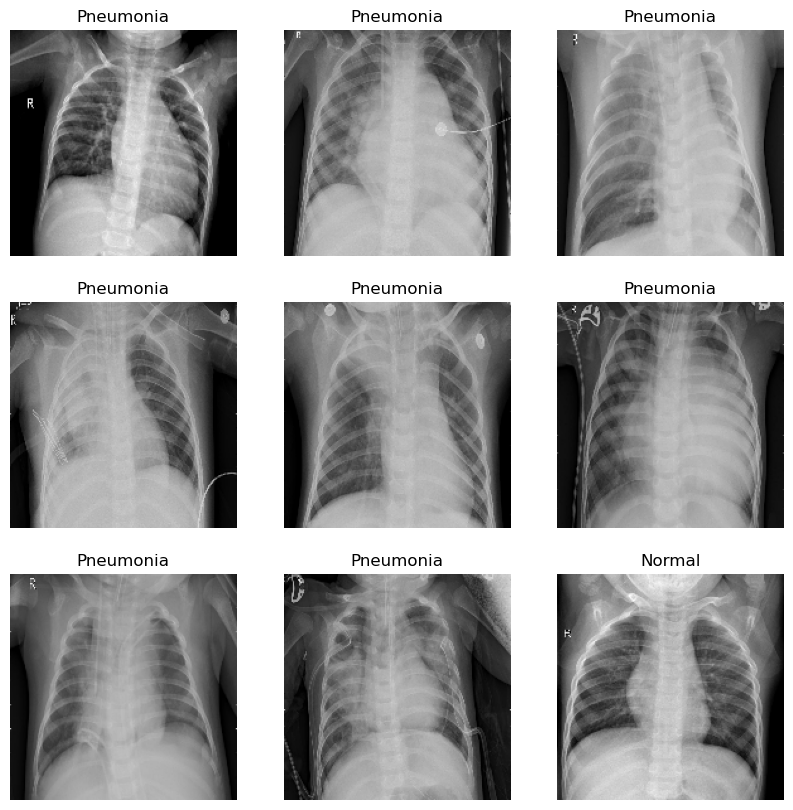

In [5]:
ploting_data(train_ds)

# 2. Data Augmentation

In [7]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

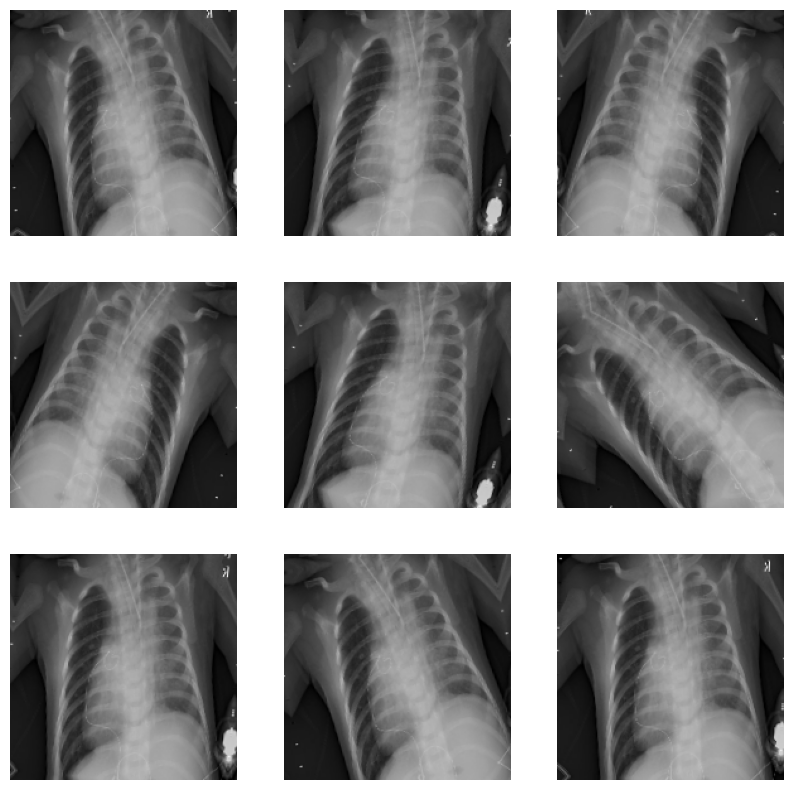

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# 3. Data modeling

In [10]:
model1 = tf.keras.Sequential([
tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),

tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu', padding='same'),
tf.keras.layers.MaxPooling2D(3, strides=2, padding='same'),
    
tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same'),
tf.keras.layers.MaxPooling2D(3, strides=2, padding='same'),

tf.keras.layers.Conv2D(256, 3, strides=2, activation='relu', padding='same'),
tf.keras.layers.MaxPooling2D(3, strides=2, padding='same'),
        
tf.keras.layers.GlobalAveragePooling2D(),

tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1, activation='sigmoid'),
])


In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
epochs = 25

model1.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy', precision_m, recall_m, f1_m])


history1 = model1.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
41/41 [==============================] - 54s 988ms/step - loss: 0.5622 - accuracy: 0.7393 - precision_m: 0.7471 - recall_m: 0.9764 - f1_m: 0.8415 - val_loss: 0.8096 - val_accuracy: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 1.0000 - val_f1_m: 0.6667
Epoch 2/25
41/41 [==============================] - 40s 837ms/step - loss: 0.3732 - accuracy: 0.8232 - precision_m: 0.8539 - recall_m: 0.9269 - f1_m: 0.8862 - val_loss: 0.9184 - val_accuracy: 0.5625 - val_precision_m: 0.5333 - val_recall_m: 1.0000 - val_f1_m: 0.6957
Epoch 3/25
41/41 [==============================] - 39s 831ms/step - loss: 0.2972 - accuracy: 0.8689 - precision_m: 0.9067 - recall_m: 0.9222 - f1_m: 0.9123 - val_loss: 0.7592 - val_accuracy: 0.5625 - val_precision_m: 0.5333 - val_recall_m: 1.0000 - val_f1_m: 0.6957
Epoch 4/25
41/41 [==============================] - 40s 834ms/step - loss: 0.2624 - accuracy: 0.8907 - precision_m: 0.9261 - recall_m: 0.9297 - f1_m: 0.9266 - val_loss: 0.8312 - val_accuracy: 0.5625 

In [12]:
def plot_history(history, epochs):
    val_acc = history.history['val_accuracy']
    tr_acc=history.history['accuracy']
    epochs = range(1, len(val_acc) +1)
    plt.plot(epochs,val_acc, 'b', label = "Validation accu")
    plt.plot(epochs, tr_acc, 'r', label = "Training accu")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.show()

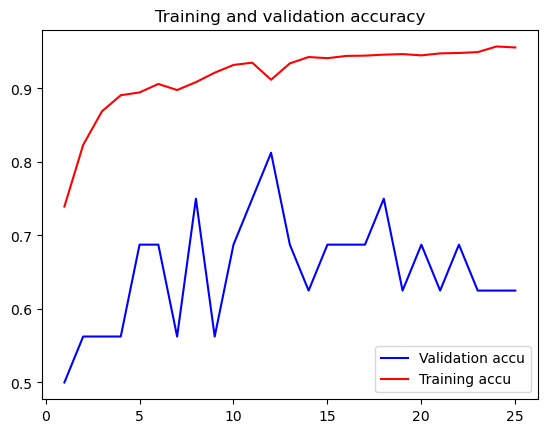

In [13]:
plot_history(history1, epochs)

In [25]:
print("Evaluate on test data")
results = model1.evaluate(test_ds)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 2s 61ms/step - loss: 0.4840 - accuracy: 0.7917 - precision_m: 0.7602 - recall_m: 0.9741 - f1_m: 0.8537
test loss, test acc: [0.48399949073791504, 0.7916666865348816, 0.7602222561836243, 0.9741098284721375, 0.8536607623100281]


In [14]:
class x_ray_model(tf.keras.Model):
    
    def __init__(self, isRescaled=True, padding='same', activation='relu'):
        super().__init__()
        self.isRescaled = isRescaled
        
        self.rescaling = tf.keras.layers.Rescaling(1.0 / 255)
        
        self.conv1 = tf.keras.layers.Conv2D(128, 3, activation=activation, strides=2, padding=padding)
        self.conv2 = tf.keras.layers.Conv2D(128, 3, activation=activation, strides=2, padding=padding)
        self.conv3 = tf.keras.layers.Conv2D(64, 3, activation=activation, strides=2, padding=padding)

        
        self.conv = tf.keras.layers.Conv2D(128, 3, strides=2, padding=padding)
        
        self.batchnorm_start = tf.keras.layers.BatchNormalization()
        self.activation_start = tf.keras.layers.Activation(activation)
        
        self.sepconv = list()
        self.res_conv = list()
        self.batchnorm = list()
        self.activation = list()
        self.add = list()
        self.maxpooling = list()
        for size in [256, 512, 728]:
            self.sepconv.append(tf.keras.layers.SeparableConv2D(size, 3, padding=padding))
            self.res_conv.append(tf.keras.layers.Conv2D(size, 1, strides=2, padding=padding))
            self.batchnorm.append(tf.keras.layers.BatchNormalization())
            self.activation.append(tf.keras.layers.Activation(activation))
            self.add.append(tf.keras.layers.Add())
            self.maxpooling.append(tf.keras.layers.MaxPooling2D(3, strides=2, padding=padding))

        
        self.dense = tf.keras.layers.Dense(64)
        
        
        self.maxpooling1 = tf.keras.layers.MaxPooling2D(3, strides=2, padding=padding)
        self.maxpooling2 = tf.keras.layers.MaxPooling2D(3, strides=2, padding=padding)
        self.maxpooling3 = tf.keras.layers.MaxPooling2D(3, strides=2, padding=padding)
        
        self.globalAvgPooling = tf.keras.layers.GlobalAveragePooling2D()
        
        self.dropout = tf.keras.layers.Dropout(0.5)
        
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')
        
        
        
    def call(self, inputs):   
        x = inputs

        if self.isRescaled:
            x = self.rescaling(inputs)
            
        x = self.conv2(x)
        x = self.maxpooling2(x)
        
        x = self.conv3(x)
        x = self.maxpooling3(x)
        
        x = self.conv1(x)
        x = self.maxpooling1(x)
        
        x = self.conv(x)
        x = self.batchnorm_start(x)
        x = self.activation_start(x)

        p = x  # Set aside residual

        for i in range(3):
            
            x = self.activation[i](x)
            x = self.sepconv[i](x)
            x = self.batchnorm[i](x)

            x = self.maxpooling[i](x)

            residual = self.res_conv[i](p)
            
            x = self.add[i]([x, residual])
            p = x  



        x = self.globalAvgPooling(x)

        x = self.dense(x)
        x = self.dropout(x)
        outputs = self.classifier(x)

        return outputs
        
    
    def model(self, size):
        x = tf.keras.layers.Input(shape=size)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))    
        

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 90, 90, 128)  3584        ['rescaling_1[0][0]']            
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 45, 45, 128)  0          ['conv2d_4[0][0]']           

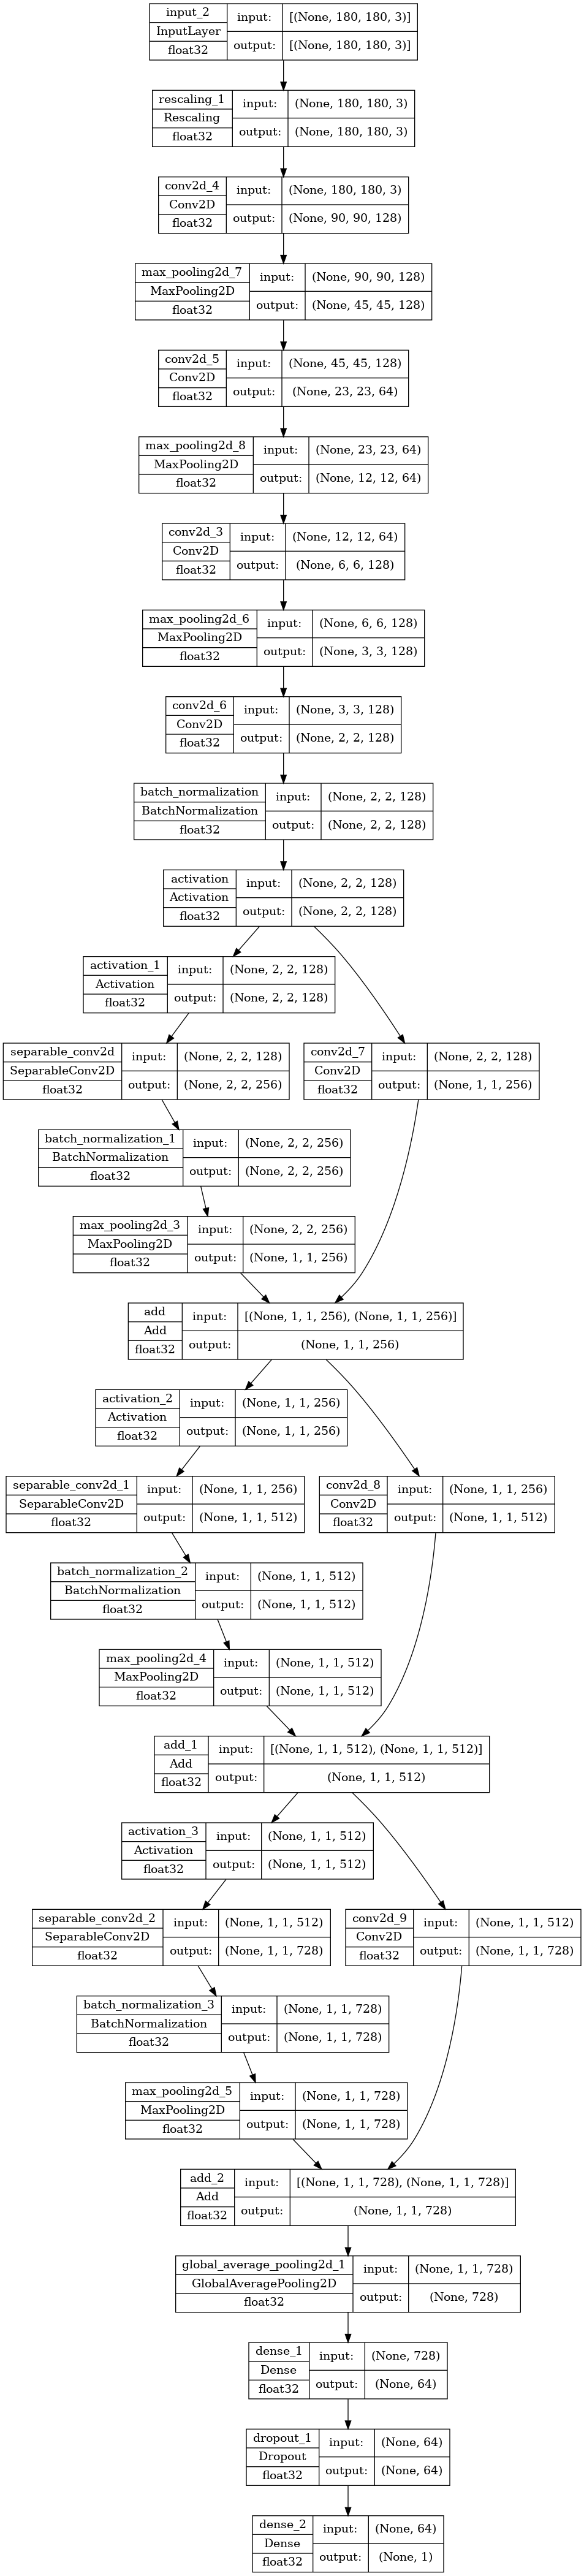

In [15]:
model2 = x_ray_model()
model2.model(image_size + (3,)).summary()

tf.keras.utils.plot_model(
    model2.model(image_size + (3,)),
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
)


In [16]:
epochs = 25

model2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy', precision_m, recall_m, f1_m])

history2 = model2.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/25
41/41 [==============================] - 45s 783ms/step - loss: 0.9134 - accuracy: 0.7866 - precision_m: 0.8449 - recall_m: 0.8600 - f1_m: 0.8433 - val_loss: 0.6919 - val_accuracy: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 1.0000 - val_f1_m: 0.6667
Epoch 2/25
41/41 [==============================] - 40s 839ms/step - loss: 0.2278 - accuracy: 0.9158 - precision_m: 0.9403 - recall_m: 0.9492 - f1_m: 0.9437 - val_loss: 0.6915 - val_accuracy: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 1.0000 - val_f1_m: 0.6667
Epoch 3/25
41/41 [==============================] - 40s 842ms/step - loss: 0.1848 - accuracy: 0.9294 - precision_m: 0.9498 - recall_m: 0.9572 - f1_m: 0.9528 - val_loss: 0.6954 - val_accuracy: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 1.0000 - val_f1_m: 0.6667
Epoch 4/25
41/41 [==============================] - 39s 830ms/step - loss: 0.1400 - accuracy: 0.9479 - precision_m: 0.9614 - recall_m: 0.9692 - f1_m: 0.9651 - val_loss: 0.6989 - val_accuracy: 0.5000 

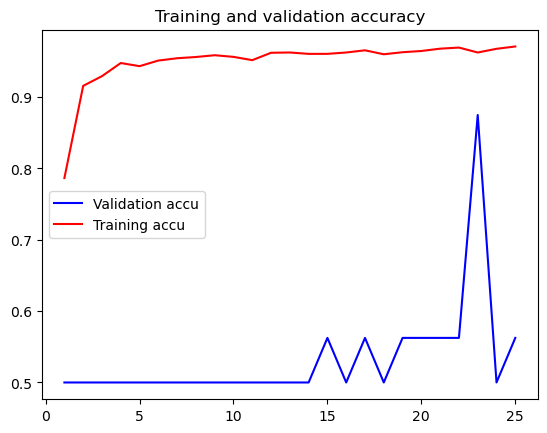

In [17]:
plot_history(history2, epochs)

In [26]:
print("Evaluate on test data")
results = model2.evaluate(test_ds)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 3s 71ms/step - loss: 1.0137 - accuracy: 0.7131 - precision_m: 0.6872 - recall_m: 0.9927 - f1_m: 0.8118
test loss, test acc: [1.0136579275131226, 0.7131410241127014, 0.6872439980506897, 0.9926966428756714, 0.8118332028388977]


In [18]:
shape_size = image_size + (3,)

transfer_model = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=shape_size)

# Freeze the pretrained weights
transfer_model.trainable = False

inputs = tf.keras.layers.Input(shape=shape_size)
x = inputs
x = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(x)
x = transfer_model(x, training=False)


# Rebuild top
x = tf.keras.layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
x = tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

x = tf.keras.layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
        
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model3 = tf.keras.Model(inputs, outputs)
    

17225924/17225924 [==============================] - 2s 0us/step


In [19]:
epochs = 25

model3.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy', precision_m, recall_m, f1_m])


history3 = model3.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25
41/41 [==============================] - 43s 843ms/step - loss: 0.2470 - accuracy: 0.8967 - precision_m: 0.9148 - recall_m: 0.9638 - f1_m: 0.9342 - val_loss: 0.1549 - val_accuracy: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000 - val_f1_m: 1.0000
Epoch 2/25
41/41 [==============================] - 40s 839ms/step - loss: 0.0842 - accuracy: 0.9695 - precision_m: 0.9800 - recall_m: 0.9794 - f1_m: 0.9794 - val_loss: 0.1440 - val_accuracy: 0.9375 - val_precision_m: 1.0000 - val_recall_m: 0.8750 - val_f1_m: 0.9333
Epoch 3/25
41/41 [==============================] - 40s 834ms/step - loss: 0.0606 - accuracy: 0.9772 - precision_m: 0.9865 - recall_m: 0.9831 - f1_m: 0.9846 - val_loss: 1.1542 - val_accuracy: 0.5625 - val_precision_m: 0.5333 - val_recall_m: 1.0000 - val_f1_m: 0.6957
Epoch 4/25
41/41 [==============================] - 39s 823ms/step - loss: 0.0560 - accuracy: 0.9778 - precision_m: 0.9862 - recall_m: 0.9840 - f1_m: 0.9849 - val_loss: 1.2829 - val_accuracy: 0.5000 

In [20]:
transfer_model.trainable = True
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 64)          589888    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 128)         7385

In [21]:
epochs = 20

model3.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy',metrics=['accuracy', precision_m, recall_m, f1_m])


history3 = model3.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
41/41 [==============================] - 57s 865ms/step - loss: 0.0226 - accuracy: 0.9929 - precision_m: 0.9954 - recall_m: 0.9946 - f1_m: 0.9949 - val_loss: 2.0609 - val_accuracy: 0.5625 - val_precision_m: 0.5333 - val_recall_m: 1.0000 - val_f1_m: 0.6957
Epoch 2/20
41/41 [==============================] - 42s 893ms/step - loss: 0.0219 - accuracy: 0.9918 - precision_m: 0.9943 - recall_m: 0.9946 - f1_m: 0.9944 - val_loss: 0.7751 - val_accuracy: 0.7500 - val_precision_m: 0.6667 - val_recall_m: 1.0000 - val_f1_m: 0.8000
Epoch 3/20
41/41 [==============================] - 42s 886ms/step - loss: 0.0193 - accuracy: 0.9927 - precision_m: 0.9949 - recall_m: 0.9956 - f1_m: 0.9952 - val_loss: 0.8708 - val_accuracy: 0.6875 - val_precision_m: 0.6154 - val_recall_m: 1.0000 - val_f1_m: 0.7619
Epoch 4/20
41/41 [==============================] - 41s 881ms/step - loss: 0.0103 - accuracy: 0.9962 - precision_m: 0.9980 - recall_m: 0.9969 - f1_m: 0.9974 - val_loss: 0.7687 - val_accuracy: 0.8125 

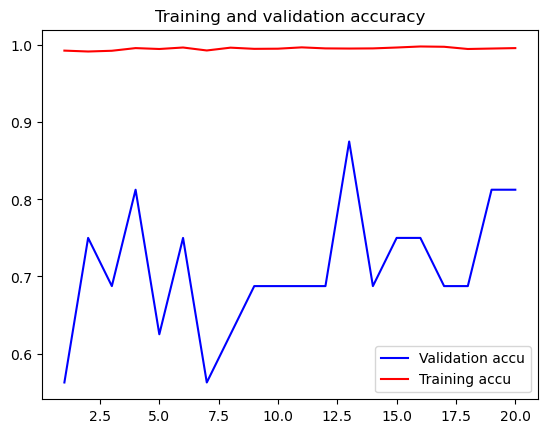

In [22]:
plot_history(history3, epochs)

In [24]:
print("Evaluate on test data")
results = model3.evaluate(test_ds)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 3s 76ms/step - loss: 1.1662 - accuracy: 0.8109 - precision_m: 0.7689 - recall_m: 0.9951 - f1_m: 0.8672
test loss, test acc: [1.1662490367889404, 0.8108974099159241, 0.7689099311828613, 0.995121955871582, 0.867247462272644]


we trained three different types of models, the first model is sequantial model and its result shows that it's not good choise. In the second model we used Model Subclassing methodology and it gave us flexibility to make our model from scratch. The second model shows better result than the first model. In the finel model we used transfer learning(our base model is MobileNet). The best result came from the third model where we used transfer learning.   